load feature maps

In [ ]:
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import os


# 文件夹1和文件夹2的路径
folder1 = "D:/PhD dissertation/portsmouth/glcm_output/"

# 获取文件夹中的所有tif文件
raster_files = [os.path.join(folder1, file) for file in os.listdir(folder1) if file.endswith(".tif")]

load vector points, extract pixels value from feature map & calcualte statistical variable

In [11]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os
import rasterio
from rasterio.windows import Window
from skimage.measure import shannon_entropy

# 读取有效点数据
valid_points = 'D:/PhD dissertation/portsmouth/vector/valid_points.shp'
new_points = gpd.read_file(valid_points)

# 定义环形区域统计量计算函数
def calculate_ring_statistics(raster, center_x, center_y, inner_radius, outer_radius, stats_functions, prefix):
    inner_radius_pixels = int(inner_radius / 4)
    outer_radius_pixels = int(outer_radius / 4)
    width_height = outer_radius_pixels * 2

    top_left_x = center_x - outer_radius_pixels
    top_left_y = center_y - outer_radius_pixels

    window = raster.read(1, window=Window(top_left_x, top_left_y, width_height, width_height))
    mask = np.zeros(window.shape, dtype=bool)
    rows, cols = np.ogrid[:width_height, :width_height]
    distance = np.sqrt((rows - outer_radius_pixels) ** 2 + (cols - outer_radius_pixels) ** 2)
    mask[distance <= outer_radius_pixels] = True
    if inner_radius_pixels > 0:
        mask[distance < inner_radius_pixels] = False
    masked_data = np.ma.masked_array(window, ~mask)

    # 使用前缀修改统计量的键名
    return {f"{prefix}_r{outer_radius}_{name}": func(masked_data.compressed()) for name, func in stats_functions.items()}

# 定义统计量计算函数，包括改进的统计量
stats_functions = {
    "mean": np.nanmean,
    "std": np.nanstd,
    "median": np.nanmedian,
    "iqr": lambda x: np.nanpercentile(x, 75) - np.nanpercentile(x, 25),
    "percentile10": lambda x: np.nanpercentile(x, 10),
    "percentile25": lambda x: np.nanpercentile(x, 25),
    "percentile75": lambda x: np.nanpercentile(x, 75),
    "percentile90": lambda x: np.nanpercentile(x, 90),
    "skewness": lambda x: pd.Series(x).skew(),
    "kurtosis": lambda x: pd.Series(x).kurt(),
    "entropy": shannon_entropy
}

temp_folder = "D:/PhD dissertation/portsmouth/dataset/"
inner_radii = [0, 30, 60, 90, 120, 150]  # 内半径列表
outer_radii = [30, 60, 90, 120, 150, 300]  # 外半径列表

for raster_file in raster_files[:3]:
    raster_prefix = os.path.splitext(os.path.basename(raster_file))[0]  # 获取栅格文件的前缀名
    print(f"Processing raster file: {raster_file}")
    with rasterio.open(raster_file) as raster:
        results = []
        for feature_idx, feature in enumerate(new_points.itertuples(), start=1):
            pixel_x, pixel_y = feature.pixel_x, feature.pixel_y
            neighborhood_results = {}
            for inner_radius, outer_radius in zip(inner_radii, outer_radii):
                stats = calculate_ring_statistics(raster, pixel_x, pixel_y, inner_radius, outer_radius, stats_functions, raster_prefix)
                neighborhood_results.update(stats)
            results.append(neighborhood_results)
            if feature_idx % 10000 == 0:
                print(f"Processed {feature_idx} points for raster file: {raster_file}")
        df = pd.DataFrame(results)
        output_file = f"{temp_folder}/{raster_prefix}_ring_stats_results.txt"
        df.to_csv(output_file, index=False)
        print(f"Ring statistics for {raster_file} saved as {output_file}")

# 合并所有结果文件
result_files = [f for f in os.listdir(temp_folder) if f.endswith("_ring_stats_results.txt")]
result_dfs = [pd.read_csv(os.path.join(temp_folder, result_file)) for result_file in result_files]

# 将Index, X_Coord, Y_Coord加入结果DataFrame
# If generate trainset, result_dfs.insert(0, new_points[['Index', 'dBA', 'x_coords', 'y_coords']])
result_dfs.insert(0, new_points[['Index', 'x_coords', 'y_coords']])


Processing raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 10000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 20000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 30000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 40000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 50000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 60000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 70000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 80000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 90000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Processed 100000 points for raster file: D:/PhD dissertation/portsmouth/glcm_output/BSI.tif
Ring statistic

combine txt to dataset .csv file, upload to colab for training and prediction

In [ ]:
temp_folder = "D:/PhD dissertation/portsmouth/dataset2/"
# 合并所有结果文件
result_files = [f for f in os.listdir(temp_folder) if f.endswith("_ring_stats_results.txt")]
result_dfs = [pd.read_csv(os.path.join(temp_folder, result_file), dtype='float32') for result_file in result_files]

# 将Index, X_Coord, Y_Coord加入结果DataFrame
result_dfs.insert(0, new_points[['Index', 'X', 'Y']])

# 合并所有结果DataFrame
final_df = pd.concat(result_dfs, axis=1)

# 保存合并后的结果文件
final_output_file = f"{temp_folder}/GNN_predset.csv"
final_df.to_csv(final_output_file, index=False)
print(f"Final results saved as {final_output_file}")


a example for normalized X and Y, better for Graph build

In [26]:
# 南安普顿的预测集坐标归一化
import pandas as pd

# 假设 final_df 已经生成
# final_df = ...

# 定义坐标的最大值和最小值
max_x, max_y = 448257, 119446
min_x, min_y = 436317, 107506


# 对 CLIP_X 和 CLIP_Y 进行归一化处理
final_df['Normalized_X'] = (final_df['CLIP_X'] - min_x) / (max_x - min_x)
final_df['Normalized_Y'] = (final_df['CLIP_Y'] - min_y) / (max_y - min_y)

# 将 Normalized_X 和 Normalized_Y 的数据类型转换为浮点型
final_df['Normalized_X'] = final_df['Normalized_X'].astype(float)
final_df['Normalized_Y'] = final_df['Normalized_Y'].astype(float)

# 移除 CLIP_X 和 CLIP_Y 列
final_df = final_df.drop(['CLIP_X', 'CLIP_Y'], axis=1)

# 保存处理后的结果文件
normalized_output_file = "E:/task0502/output/normalized_GNN_predset.csv"
final_df.to_csv(normalized_output_file, index=False)
print(f"Normalized final results saved as {normalized_output_file}")

Normalized final results saved as E:/task0502/output/normalized_GNN_predset.csv


if generate training dataset, dataset divided to train/val/test, based on X,Y,label

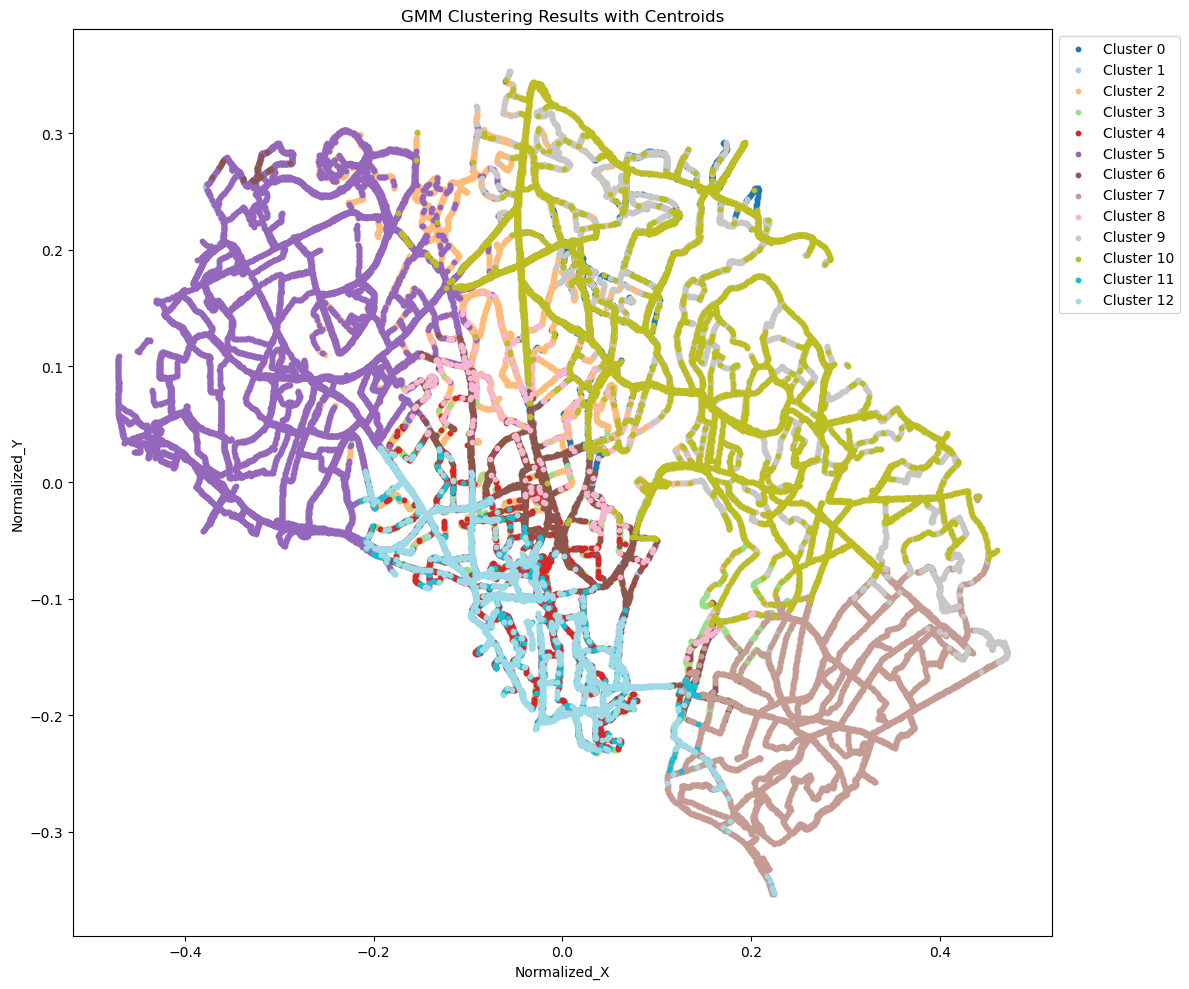

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture

# 加载数据
output_csv = "D:/PhD dissertation/soton/dataset/merged_GNN_genset.csv"
df = pd.read_csv(output_csv)

# 选取特征
X = result_df[['Normalized_X', 'Normalized_Y', 'Average_Clip_dBA']].copy()

# 创建GMM模型
gmm = GaussianMixture(n_components=13, max_iter=1000, tol=1e-3, random_state=43, init_params='kmeans')
gmm_labels = gmm.fit_predict(X)

# 将聚类标签添加到数据框中
df['GMM_Cluster'] = gmm_labels

# 聚类中心
centers = gmm.means_[:, :2]

# 可视化聚类结果
plt.figure(figsize=(12, 10))
colors = plt.cm.tab20(np.linspace(0, 1, gmm.n_components))  # 使用tab20颜色映射，生成12个不同的颜色

for cluster, color in zip(range(gmm.n_components), colors):
    # 画出聚类散点图
    cluster_data = df[df['GMM_Cluster'] == cluster]
    plt.scatter(cluster_data['Normalized_X'], cluster_data['Normalized_Y'], s=10, color=color, label=f'Cluster {cluster}')
    # 画出聚类中心
    # plt.scatter(centers[cluster, 0], centers[cluster, 1], s=200, color=color, edgecolors='black', marker='o', label=f'Centroid {cluster}')

plt.title('GMM Clustering Results with Centroids')
plt.xlabel('Normalized_X')
plt.ylabel('Normalized_Y')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 将图例放置在图外
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()


In [ ]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

# 加载数据
output_csv = 'D:/PhD dissertation/soton/dataset/merged_GNN_genset.csv'
df = pd.read_csv(output_csv)

# 将所有 float64 类型的列转换为 float32
float_cols = df.select_dtypes(include=['float64']).columns
df[float_cols] = df[float_cols].astype('float32')

# 检查转换后的数据类型和内存使用情况
print(df.info(memory_usage='deep'))

# 提取特征
X = df[['Normalized_X', 'Normalized_Y', 'Average_Clip_dBA']].copy()

# 运行GMM
gmm = GaussianMixture(n_components=13, max_iter=1000, tol=1e-3, random_state=43, init_params='kmeans')
gmm_labels = gmm.fit_predict(X)

# 将GMM聚类标签添加到DataFrame
df['Cluster'] = gmm_labels

# 分层抽样
train_val, test = train_test_split(df, test_size=0.2, stratify=df['Cluster'], random_state=42)
train, val = train_test_split(train_val, test_size=0.25, stratify=train_val['Cluster'], random_state=42)

# 输出划分结果的概览和保存数据集
print(f"Training set size: {len(train)}, Validation set size: {len(val)}, Test set size: {len(test)}")

# 保存数据集
train.to_csv('D:/PhD dissertation/soton/dataset/GNN_train.csv', index=False)
val.to_csv('D:/PhD dissertation/soton/dataset/GNN_validation.csv', index=False)
test.to_csv('D:/PhD dissertation/soton/dataset/GNN_test.csv', index=False)
